# Introduction into Radiomics

14.12.2020 E. Lavrova

In this script, you can find a very basic information about radiomic analysis. You can find description of Radiomics concepts in the following papers:  
* Aerts, H. J., Velazquez, E. R., Leijenaar, R. T., Parmar, C., Grossmann, P., Carvalho, S., ... & Hoebers, F. (2014). Corrigendum: Decoding tumour phenotype by noninvasive imaging using a quantitative radiomics approach. Nature communications, 5. https://dx.doi.org/10.1038%2Fncomms5644  
* Lambin, P., Rios-Velazquez, E., Leijenaar, R., Carvalho, S., Van Stiphout, R. G., Granton, P., ... & Aerts, H. J. (2012). Radiomics: extracting more information from medical images using advanced feature analysis. European journal of cancer, 48(4), 441-446. https://doi.org/10.1016/j.ejca.2011.11.036  
* Lambin, P., Leijenaar, R. T., Deist, T. M., Peerlings, J., De Jong, E. E., Van Timmeren, J., ... & van Wijk, Y. (2017). Radiomics: the bridge between medical imaging and personalized medicine. Nature reviews Clinical oncology, 14(12), 749-762. https://doi.org/10.1038/nrclinonc.2017.141 

<b>Radiomics pipeline</b>
  
![](../data/img/pipeline.png)

The typical pipeline of radiomic analysis consists of the following steps:  
* segmentation of the region of interest (ROI),  
* radiomic features extraction - calculation of numerous simple mathematical descriptors of ROI,  
* radiomic features selection - selection of the radiomic features, which are informative and provide the top performing models,  
* modeling - ML solution for classification/regression/clustering/...
  
The goal of this tutorial is to build a basic Radiomics pipeline aimed to perform prediction of a clinical outcome - 1.5 year survival (disclaimer: this is a training task, we are not doing an advanced survival analysis, we are just predicting a binary label). Within this tutorial, we will extract radiomic features with pyradiomics (https://pyradiomics.readthedocs.io/en/latest/) package, select the best features, train and test the model.

## Data download

The Lung1 dataset contains pretreatment scans of 422 non-small cell lung cancer (NSCLC) patients, as well as manually deliniated gross tumor volume (GTV) for each patient and clinical outcomes. More information you can find on the dataset web page and in the corresponding paper https://doi.org/10.1038/ncomms5006. For consistency, we recommend you to download the data to the '../data' folder of this project. You can find the data and its description following the link below:  
https://wiki.cancerimagingarchive.net/display/Public/NSCLC-Radiomics
  
To download the dataset, you might need to install the download manager:
https://wiki.cancerimagingarchive.net/display/NBIA/Downloading+TCIA+Images#DownloadingTCIAImages-DownloadingtheNBIADataRetriever

Finally, you will have the '../data/NSCLC-Radiomics' folder with CT images (it will require 33 GB of disc space!). Additionally, download '.csv' file to the '../data' folder. 

For this tutorial, you would need the PM-toolbox, which will help with a preliminary data analysis. To download a toolbox, download or clone the following repository and place it anywhere on your hard drive:  
https://github.com/precision-medicine-um/precision_medicine_toolbox.   
Please specify below the path to the PM-toolbox folder:

In [13]:
pm_toolbox_path = 'C:/users/e.lavrova/documents/github/precision_medicine_toolbox'

To view the medical images, you can write python script or you can start with using one of these tools: 
* 3D Slicer (supports different formats, has numerous plugins) https://www.slicer.org/  
* Radiant (DICOM viewer) https://www.radiantviewer.com/  
* mricron (for Nifti format) https://people.cas.sc.edu/rorden/mricron/index.html

## Managing python packages

To proceed, make sure you have all the python packages installed (or install it with the following line of code from Jupyter).

In [3]:
!pip install -r ../requirements.txt

Import the packages:

In [52]:
import os,sys

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, confusion_matrix, roc_curve
import seaborn as sn

%matplotlib inline

pd.set_option('display.max_rows', 500)

Import the toolbox

In [14]:
sys.path.append(os.path.abspath(pm_toolbox_path))
from tool_box import tool_box
from features_set import features_set

## Dataset exploration

If you want to get a better knowledge of your data, you can do some basic dataset exploration steps. We propose to do it with a PM-toolbox (more information and examples are in PM toolbox example scripts).

In [ ]:
parameters = {'data_path': r'../data/NSCLC-Radiomics/', #path_to_your_data
              'data_type': 'dcm'} 

data_dcms = tool_box(**parameters)
dataset_description = data_dcms.get_dataset_description('CT') 

dataset_description.head(3)

In [ ]:
#Lets plot some of the scans parameters

sb.set(context='poster', style='whitegrid')

study_date = sorted([ 'Nan' if x=='' or x=='NaN' else str(x[0:4]) for x in list(dataset_description['SeriesDate'])])[2:]
conv_kernel =['Nan' if x=='' or x=='NaN' else x for x in list(dataset_description['ConvolutionKernel'])]
tube_current =[-1 if x=='' or x=='NaN' else x for x in list(dataset_description['XRayTubeCurrent'])]
exposure =[-1 if x=='' or x=='NaN' else x for x in list(dataset_description['Exposure'])]
ps = sorted([(x[0]) for x in list(filter(lambda x: x != 'NaN', dataset_description['PixelSpacing'].values))])
sl_th = sorted([str(x)[0:3] for x in list(filter(lambda x: x != 'NaN', dataset_description['SliceThickness'].values))])
figures,descriptions = [study_date,conv_kernel,tube_current,exposure,ps,sl_th],['Study Date','Conv Kernel','Tube Current','Exposure','Pixel spacing','Slice Thickness']

fig,ax = plt.subplots(2,3,figsize=(25,15))
for i in range(2):
    for j in range(3):
        ax[i,j].hist(figures.pop(0),alpha=0.7)
        ax[i,j].set_title(descriptions.pop(0),fontsize=20)
    

## Data conversion

The industrial medical imaging format is DICOM (https://www.dicomstandard.org/). This means, that you usually get the DICOM data from medical scanners. But often it's much more convenient to work with open source data formats (Nrrd https://en.wikipedia.org/wiki/Nrrd, or Nifti https://nifti.nimh.nih.gov/ for brain imaging), moreover, some of the tools for image analysis do not support DICOM. That's why in most of the cases we need to convert the data.

In [ ]:
# Set up the parameters to convert it to nrrd
parameters = {'data_path': r'../data/NSCLC-Radiomics/', 
              'data_type': 'dcm',
              'multi_rts_per_pat': False}
                  
export_path =r'../data/converted_nrrds/' # nrrd files will be saved to this folder
data_ct = tool_box(**parameters) 

# conversion
data_ct.convert_to_nrrd(export_path,'gtv')

## Features extraction

There are several software packages to extract the radiomic features:
* Pyradiomics for python https://pyradiomics.readthedocs.io/en/latest/
* Oncoradiomics https://www.oncoradiomics.com/  
* Radiomics by Vallieres for MATLAB https://github.com/mvallieres/radiomics
* Radiomics by Carlson for R https://www.rdocumentation.org/packages/radiomics/versions/0.1.3

In this tutorial, we will use Pyradiomics. You can read the full documentation for the currently stable version: https://pyradiomics.readthedocs.io/_/downloads/en/stable/pdf/. 

With Pyradiomics, you can extract features from different image types:
* from original image 
* from this image after some transformation, such as: 
    * wavelet filtering,   
    * LoG filtering, 
    * squared intensities, 
    * square rooted intensities, 
    * logarythm of the absolute intensity, 
    * exponential of intensities, 
    * gradient map, 
    * LocalBinaryPatterns.   

The following feature classes are supported:
* firstorder - basic statistics of ROI intensities,
* shape - shape descriptors,  
* statistics of various texture matrices:
    * GLCM (https://doi.org/10.1109/TSMC.1973.4309314),
    * GLRLM (https://doi.org/10.1016/S0146664X(75)800086),
    * GLSZM (https://doi.org/10.1142/S0218001413570024),
    * GLDM (https://doi.org/10.1109/21.44046),
    * NGTDM (https://doi.org/10.1016/0734-189X(83)90032-4).

<b>Radiomic features taxonomy</b>
  
![](../data/img/features.png)

While extracting the features, you need to define numerous parameters, such as intensities normalization, intensities discretization for grey level matrices calculation, resampling, padding, etc. There are recommendations you can rely on while extracting the features: https://arxiv.org/abs/1612.07003. 

The other question is which features are usually to be extracted. It is always better to extract as many features as possible (== all the features you can calculate with your software) and perform feature selection. If you need to save time or your dataset is small (n_features >> n_samples), which decreases the significance of feature selection results and increases the risk of overfitting, you can stick to the features extracted only from the original image.

In [ ]:
data_ct_nrrd = tool_box(data_path = r'../data/converted_nrrds/', data_type='nrrd')

#Use your own pyradiomics parameters .yaml file, more you can find here: https://github.com/Radiomics/pyradiomics 
parameters = pm_toolbox_path + '/example_ct_parameters.yaml' 
features = data_ct_nrrd.extract_features(parameters, loggenabled=True)

#Write features to excel file
writer = pd.ExcelWriter(training_project_path + '/results/extracted_features.xlsx')
features.to_excel(writer,'Sheet1')
writer.save()

## Otcomes generation

Loading and printing the clinical data for Lung1 dataset:

In [8]:
clinical_df = pd.read_csv('../data/NSCLC Radiomics Lung1.clinical-version3-Oct 2019.csv')
clinical_df

,PatientID,age,clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Overall.Stage,Histology,gender,Survival.time,deadstatus.event
0,LUNG1-001,78.7515,2.0,3,0,IIIb,large cell,male,2165,1
1,LUNG1-002,83.8001,2.0,0,0,I,squamous cell carcinoma,male,155,1
2,LUNG1-003,68.1807,2.0,3,0,IIIb,large cell,male,256,1
3,LUNG1-004,70.8802,2.0,1,0,II,squamous cell carcinoma,male,141,1
4,LUNG1-005,80.4819,4.0,2,0,IIIb,squamous cell carcinoma,male,353,1
5,LUNG1-006,73.8864,3.0,1,0,IIIa,squamous cell carcinoma,male,173,1
6,LUNG1-007,81.5288,2.0,2,0,IIIa,squamous cell carcinoma,male,137,1
7,LUNG1-008,71.6660,2.0,2,0,IIIa,adenocarcinoma,male,77,1
8,LUNG1-009,56.1342,2.0,2,0,IIIa,squamous cell carcinoma,male,131,1
9,LUNG1-010,71.0554,4.0,3,0,IIIb,squamous cell carcinoma,female,2119,0


The clinical data contains age, gender, disease stage, histology, survival time and death status. We need to create a new column with binary variable, corresponding to 1.5 year survival (0 - no, 1 - yes).

In [9]:
# function for 1.5 year survival estimation, based on survival time and death status variables.

def survival_estimation(row):
    year = 1.5
    year_duration = 365
    if row['Survival.time'] >= year*year_duration:
        val = 1
    elif row['deadstatus.event'] == 1:
        val = 0
    else:
        val = None
    return val

Adding a new column with outcome variable and saving a dataframe to a new .csv file.

In [10]:
clinical_df['1.5yearsurvival'] = clinical_df.apply(survival_estimation, axis=1)
clinical_df.to_csv('../results/survival_data.csv', index = False)
clinical_df

,PatientID,age,clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Overall.Stage,Histology,gender,Survival.time,deadstatus.event,1.5yearsurvival
0,LUNG1-001,78.7515,2.0,3,0,IIIb,large cell,male,2165,1,1.0
1,LUNG1-002,83.8001,2.0,0,0,I,squamous cell carcinoma,male,155,1,0.0
2,LUNG1-003,68.1807,2.0,3,0,IIIb,large cell,male,256,1,0.0
3,LUNG1-004,70.8802,2.0,1,0,II,squamous cell carcinoma,male,141,1,0.0
4,LUNG1-005,80.4819,4.0,2,0,IIIb,squamous cell carcinoma,male,353,1,0.0
5,LUNG1-006,73.8864,3.0,1,0,IIIa,squamous cell carcinoma,male,173,1,0.0
6,LUNG1-007,81.5288,2.0,2,0,IIIa,squamous cell carcinoma,male,137,1,0.0
7,LUNG1-008,71.6660,2.0,2,0,IIIa,adenocarcinoma,male,77,1,0.0
8,LUNG1-009,56.1342,2.0,2,0,IIIa,squamous cell carcinoma,male,131,1,0.0
9,LUNG1-010,71.0554,4.0,3,0,IIIb,squamous cell carcinoma,female,2119,0,1.0


## Features exploration

Before features selection, we will look at our features.

In [17]:
# set up the parameters
parameters = {
    'feature_path': "../results/extracted_features.xlsx", # path to csv/xls file with features
    'outcome_path': "../results/survival_data.csv", #path to csv/xls file with outcome
    'patient_column': 'Patient', # name of column with patient id
    'patient_in_outcome_column': 'PatientID', # name of column with patient id in clinical data file
    'outcome_column': '1.5yearsurvival' # name of outcome column
}

# initialize feature set
fs = features_set(**parameters)

Number of observations: 149
Class labels: ['0.0' '1.0']
Classes balance: [0.5503355704697986, 0.44966442953020136]


The following functions are creating .html reports with some basic analysis results.

In [19]:
# visualization of feature values distribution in classes (in .html report)
# could be inserted it into paper of presentation to illustrate the features distribution within classes
fs.plot_distribution(fs._feature_column[:100])

In [21]:
# visualization of feature mutual (Spearman) correlation coefficient matrix (in .html report)
# to have an idea on how many features are intercorrelated
fs.plot_correlation_matrix(fs._feature_column[:100])

In [22]:
# visualization of Mann-Whitney Bonferroni corrected p-values for binary classes test (in .html report)
# an objective measure of differences of feature values distribution within classes
fs.plot_MW_p(fs._feature_column[:100])

In [23]:
# visualization of univariate ROC-curves (in .html report)
# the same information as in distributions plotting, but another representation
fs.plot_univariate_roc(fs._feature_column[:100])

In [24]:
# calculation of basic statistics for each feature (in .xlsx):
# number of NaN, mean, std, min, max; if applicable: MW-p, univariate ROC AUC, volume correlation
fs.calculate_basic_stats(volume_feature='original_shape_VoxelVolume')

In [25]:
# volume analysis
# we always want to know if the features are correlated to volume to be sure that we are not analyzing volumes
fs.volume_analysis(volume_feature='original_shape_VoxelVolume')

## Dataset split

Before beginning the analysis, we need to split the dataset into train and test subsets. We will use train subset to select the features and train the model. The test subset is kept apart from the training data and used ONLY for the testing purposes.

In [51]:
# reading the data
radiomics_df = pd.read_excel('../results/extracted_features.xlsx')

# keeping only GTV1 (primary tumor) contours 
radiomics_df.drop(radiomics_df.loc[radiomics_df['ROI']!= 'GTV-1_mask'].index, inplace=True)

# getting rid of the 'technical' columns 
radiomics_df = radiomics_df[radiomics_df.columns[38:-1]].copy()

# creating new column with patient ID instead of ID + series ID + ROI ID
def patient_id_estimation(row):
    val = row['Patient'][:9]
    return val
radiomics_df['PatientID'] = radiomics_df.apply(patient_id_estimation, axis=1)
radiomics_df.drop(columns = ['Patient'], inplace = True)
radiomics_df.drop_duplicates(inplace = True)

# merging dataframes with clinical data and radiomic features
df = pd.merge(clinical_df, radiomics_df, on='PatientID', how = 'left')

# for some patients, there are records in clinical dataframe, but there is no imaging data, therefore, no features
# for some patients, we have imaging data, but survival variable can be absent 
# (for example, due to 0 death status and survival < 1.5 years)
# we cannot use this data for model building, therefore, we drop this data
df.dropna(subset=df.columns[10:], inplace = True)

# data split (trying to maintain proportion of outcomes in train and test subsets)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1, stratify=df[['1.5yearsurvival']])

# outcomes in the whole dataset and its subsets
print ('Dataset - total, survived, did not survive: ', len(df),
       len(df.loc[df['1.5yearsurvival'] == 1]), len(df.loc[df['1.5yearsurvival'] == 0]))
print ('Train subset - total, survived, did not survive: ', len(df_train),
       len(df_train.loc[df_train['1.5yearsurvival'] == 1]), 
       len(df_train.loc[df_train['1.5yearsurvival'] == 0]))
print ('Test subset - total, survived, did not survive: ', len(df_test),
       len(df_test.loc[df_test['1.5yearsurvival'] == 1]), 
       len(df_test.loc[df_test['1.5yearsurvival'] == 0]))



Dataset - total, survived, did not survive:  145 67 78
Train subset - total, survived, did not survive:  116 54 62
Test subset - total, survived, did not survive:  29 13 16


## Features selection

We have extracted many features, but some of them are not informative for our task, many of them are correlated to each other, therefore, redundant. To decrease data noise and avoid overfitting, features selection is needed. In different studies, different features selection strategies are used. You can find some basic information in papers and notes following these links:  
https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e  
https://machinelearningmastery.com/feature-selection-machine-learning-python/  
https://www.ncbi.nlm.nih.gov/pubmed/30280245  
https://www.frontiersin.org/articles/10.3389/fonc.2019.01393/full  
We are proposing the following strategy:
* dropping the features, which are constants or have one predominant value, so that these features are not informative (implemented in R https://www.rdocumentation.org/packages/caret/versions/6.0-86/topics/nearZeroVar, we'll write the same function in python)
* dropping the features, which are correlated to each other (from each pair of highly correlated features (|r_S|>0.85), we excluded a feature having the highest correlation on average with all the remaining features),
* with recursive feature elimination (RFE) selecting the combination of features, which gives the best model performance (based on some selected machine learning model - we used Random Forest).

The key part is RFE, but it needs a reduced number of features as an input. You can read more about it:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV
https://www.scikit-yb.org/en/latest/api/model_selection/rfecv.html
https://medium.com/@aneesha/recursive-feature-elimination-with-scikit-learn-3a2cbdf23fb7


In [31]:
# defining functions for selection of features with non-zero-variance and not highly correlated features

def selectNonUniform(df_in, ftrs, outc):
    
    # selection of the features, which have non-low variance; 
    
    # input:
    # df_in - input dataframe, containing feature values (dataframe, columns = features, rows = observations),
    # ftrs - list of dataframe features, used in analysis (list of feature names - string variables),
    # outc - name of dataframe outcome variable (string),
    
    # output:
    # non_uniform_features - list of feature names (list of string)     
    
    non_uniform_features = []
    
    for ftr in ftrs:
        
        ftr_freqs = pd.DataFrame(df_in[ftr].round(2).value_counts())
        if len(ftr_freqs) > 1: 
            f1 = int(ftr_freqs.iloc[0])
            f2 = int(ftr_freqs.iloc[1])
            f = len(ftr_freqs)
            p1 = f/len(df_in[ftrs])

            p2 = f1/f2
            if p1<=0.1 and p2 >= 95/5:
                print (ftr,  ' excluded')
            else:
                non_uniform_features.append(ftr)
        else:
            print (ftr, ' excluded')
    
    print ('Non uniform features: ', non_uniform_features)
    
    return non_uniform_features

def selectNonIntercorrelated(df_in, ftrs, outc, corr_th):
    
    # selection of the features, which are not 'highly intercorrelated' (correlation is defined by Spearman coefficient);
    # pairwise correlation between all the features is calculated, 
    # from each pair of features, considered as intercorrelated, 
    # feature with maximum sum of all the pairwise Spearman correlation coefficients is a 'candidate to be dropped'
    
    # input:
    # df_in - input dataframe, containing feature values (dataframe, columns = features, rows = observations),
    # ftrs - list of dataframe features, used in analysis (list of feature names - string variables),
    # outc - name of dataframe outcome variable (string),
    # corr_th - threshold for Spearman correlation coefficient, defining each pair of features as intercorrelated (float)
    
    # output:
    # non_intercorrelated_features - list of feature names (list of string) 
    
    corr_matrix = df_in.corr(method='spearman').abs()
    mean_absolute_corr = corr_matrix.mean()
    intercorrelated_features_set = []
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    high_corrs = upper.where(upper > corr_th).dropna(how='all', axis=1).dropna(how='all', axis=0)

    for feature in high_corrs.columns:
        mean_absolute_main = mean_absolute_corr[feature]
        correlated_with_feature = high_corrs[feature].index[pd.notnull(high_corrs[feature])]
        for each_correlated_feature in correlated_with_feature:
            mean_absolute = mean_absolute_corr[each_correlated_feature]
            if mean_absolute_main > mean_absolute:
                if feature not in intercorrelated_features_set:
                    intercorrelated_features_set.append(feature)
            else:
                if each_correlated_feature not in intercorrelated_features_set:
                    intercorrelated_features_set.append(each_correlated_feature)

    non_intercorrelated_features_set = [e for e in ftrs if e not in intercorrelated_features_set] 
    
    print ('Non intercorrelated features: ', non_intercorrelated_features_set)
    
    return non_intercorrelated_features_set

In [41]:
# no-zero-variance
non_uniform_features = selectNonUniform(df_train, df_train.columns[11:], '1.5yearsurvival')

original_gldm_SmallDependenceLowGrayLevelEmphasis  excluded
log-sigma-1-0-mm-3D_gldm_SmallDependenceLowGrayLevelEmphasis  excluded
log-sigma-2-0-mm-3D_gldm_SmallDependenceLowGrayLevelEmphasis  excluded
log-sigma-3-0-mm-3D_gldm_SmallDependenceLowGrayLevelEmphasis  excluded
log-sigma-4-0-mm-3D_gldm_SmallDependenceLowGrayLevelEmphasis  excluded
log-sigma-5-0-mm-3D_gldm_SmallDependenceLowGrayLevelEmphasis  excluded
wavelet-LLH_gldm_SmallDependenceLowGrayLevelEmphasis  excluded
wavelet-LHL_gldm_SmallDependenceLowGrayLevelEmphasis  excluded
wavelet-HLL_gldm_SmallDependenceLowGrayLevelEmphasis  excluded
wavelet-HHH_firstorder_Entropy  excluded
wavelet-HHH_firstorder_Uniformity  excluded
wavelet-HHH_glcm_SumSquares  excluded
wavelet-HHH_glrlm_GrayLevelNonUniformityNormalized  excluded
wavelet-HHH_glrlm_GrayLevelVariance  excluded
wavelet-HHH_glszm_ZonePercentage  excluded
wavelet-HHH_gldm_GrayLevelVariance  excluded
wavelet-HHH_gldm_SmallDependenceEmphasis  excluded
wavelet-LLL_glrlm_LongRunLo

Non uniform features:  ['original_shape_Elongation', 'original_shape_Flatness', 'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume', 'original_shape_MinorAxisLength', 'original_shape_Sphericity', 'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio', 'original_shape_VoxelVolume', 'original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firs

In [42]:
# no intercorrelated
non_intercorrelated_features = selectNonIntercorrelated(df_train, non_uniform_features, '1.5yearsurvival', 0.85)

Non intercorrelated features:  ['original_shape_Elongation', 'original_shape_Flatness', 'original_shape_MajorAxisLength', 'original_shape_Sphericity', 'original_firstorder_Median', 'original_firstorder_Skewness', 'original_glcm_ClusterShade', 'original_glcm_Correlation', 'original_glcm_Imc1', 'original_glcm_Imc2', 'original_glrlm_LongRunLowGrayLevelEmphasis', 'original_glszm_GrayLevelVariance', 'original_glszm_LowGrayLevelZoneEmphasis', 'log-sigma-1-0-mm-3D_firstorder_90Percentile', 'log-sigma-1-0-mm-3D_firstorder_Maximum', 'log-sigma-1-0-mm-3D_firstorder_Minimum', 'log-sigma-1-0-mm-3D_firstorder_Skewness', 'log-sigma-1-0-mm-3D_glcm_ClusterShade', 'log-sigma-1-0-mm-3D_glcm_Correlation', 'log-sigma-1-0-mm-3D_glcm_Imc1', 'log-sigma-1-0-mm-3D_glcm_Imc2', 'log-sigma-1-0-mm-3D_glcm_InverseVariance', 'log-sigma-1-0-mm-3D_glrlm_RunEntropy', 'log-sigma-1-0-mm-3D_glszm_SizeZoneNonUniformityNormalized', 'log-sigma-1-0-mm-3D_gldm_DependenceVariance', 'log-sigma-2-0-mm-3D_firstorder_Maximum', 'log

In [43]:
# RFE

# defining the model to test combinations of features
estimator = RandomForestClassifier(n_estimators=100, random_state=np.random.seed(0))
# defining selector - RFE with 10-fold cross validation
selector = RFECV(estimator, step=1, cv=10)
# fitting the selector on the data
selector = selector.fit(df_train[non_intercorrelated_features], df_train['1.5yearsurvival'])
# getting the selected features
support = selector.get_support()
selected_features = df_train[non_intercorrelated_features].loc[:, support].columns.tolist()

In [45]:
print ('number of features - original, with non-zero-variance, non-intercorrelated, selected: ', 
       len(df_train.columns[11:]), len(non_uniform_features), len(non_intercorrelated_features), len(selected_features))

number of features - original, with non-zero-variance, non-intercorrelated, selected:  1218 1194 170 9


## Model training and testing

After we've got the final feature vector, reducing the original feature set of 1218 features to 9, we can train and test the model. For this tutorial, we are using Random Forest, because it does not require scaling of the input data and does not tend to overfit. It is possible to replace it with other model.

In [50]:
# training the model
estimator.fit(df_train[selected_features], df_train['1.5yearsurvival'])

# getting predictions on the test data
survival_pred = estimator.predict(df_test[selected_features])

# getting getting class probabilities on the test data
survival_score = estimator.predict_proba(df_test[selected_features])[:,1]

# getting the classification scores
acc = accuracy_score(df_test['1.5yearsurvival'], survival_pred)
auc = roc_auc_score(df_test['1.5yearsurvival'], survival_score)
sens = recall_score(df_test['1.5yearsurvival'], survival_pred)
spec = recall_score(df_test['1.5yearsurvival'], survival_pred, pos_label = 0)

print ('Accuracy, ROC AUC, sensitivity, specificity: ', acc, auc, sens, spec)

Accuracy, ROC AUC, sensitivity, specificity:  0.6896551724137931 0.6538461538461539 0.6923076923076923 0.6875


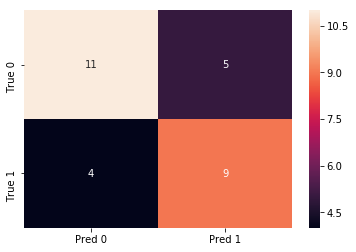

In [55]:
# plotting confusion matrix

cm = confusion_matrix(df_test['1.5yearsurvival'], survival_pred)
df_cm = pd.DataFrame(cm, index = ['True 0', 'True 1'], columns = ['Pred 0', 'Pred 1'])
sn.heatmap(df_cm, annot=True)
plt.title('Confusion matrix')
plt.show()

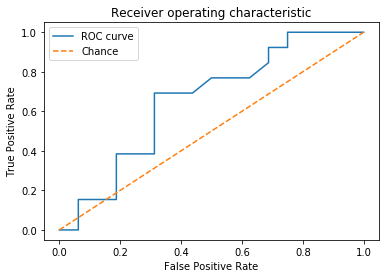

In [160]:
# plotting ROC

fpr, tpr, thresholds = roc_curve(df_test['1.5yearsurvival'], survival_score)
plt.plot(fpr, tpr, label = 'ROC curve')
plt.plot([0, 1], [0, 1], label = 'Chance', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend()
plt.show()

Finally, we built a classification model. It was not a survival analysis, just a training task, giving a feeling of data and methods. The scores are not impressive, which is due to the amount of data, incompleteness of the input variables (to predict survival, we need to consider clinical information), and imperfection of the pipeline (again, it was a very basic pipeline). There are two remarks on the delivery of the classification results:
* we used the common classification performance metrics, but the data is not perfectly balanced -> subsampling approaches while training + considering the metrics for unbalanced test data (precision, recall, precision-recall curve instead of ROC, etc.) or data balancing strategies,
* we used point estimation of the metrics on test set to demonstrate the model operation; nevertheless, while reporting the results, we need to provide average values with confidence intervals to show the variability of results -> subsampling approaches while testing